# Задание

Вам предстоит поработать с данными о стабильности белков (`tm`). Нужно по последовательности белка и по `pH` предсказывать стабильность. Так как это дополнительное задание, то комментариев и подробного плана не будет, вам нужно максимально показать свои знания и постараться добиться наилучшего качества.

Небольшой план для начала:

1. Провести небольшой EDA, найти возможные выбросы и понять, в чем может быть дело.
2. Придумать, как закодировать аминокислотные последовательности в числовые векторы.
3. Разделить данные на `train` и `test` (подумать над правильной стратегией разбиения).
4. Используя кросс-вадидацию подобрать наилучшую модель на тренировочных данных.
5. Обучить лучшую модель на всех тренировочных данных.
5. Протестировать лучшую модель на тестовых данных.

Оформить подробный отчет в виде ноутбука. Постарайтесь воспользоваться всеми техниками, которые мы прошли в курсе.

*Так как текущее задание в довольно свободной форме, то четких критериев оценки нет. Если минимально проследовать вышеуказанным рекомендациям, то можно получить до **20 баллов**. Максимально за это задание можно получить **40***.

In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error, mean_absolute_error)
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression


In [62]:
data_folder = "data"
data_filename = "data.csv"
data_path = join(data_folder, data_filename)

In [85]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [86]:
data = data.drop('data_source',  axis=1)

In [87]:
data = data.dropna()

In [88]:
data.shape

(31104, 3)

1. EDA

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31104 entries, 0 to 31389
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  31104 non-null  object 
 1   pH                31104 non-null  float64
 2   tm                31104 non-null  float64
dtypes: float64(2), object(1)
memory usage: 972.0+ KB


In [90]:
data.describe()

,pH,tm
count,31104.000000,31104.000000
mean,6.892339,49.150608
std,1.612225,14.044705
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.100000
75%,7.000000,53.800000
max,64.900000,130.000000


Минимальное значение стабильности составляет -1.0, что может быть выбросом. Согласуется с большим стандартным отклонением. В значениях pH вроде такой вариабельности нет, хотя максимальная pH 64.9 настораживает,  такой не бывает. 


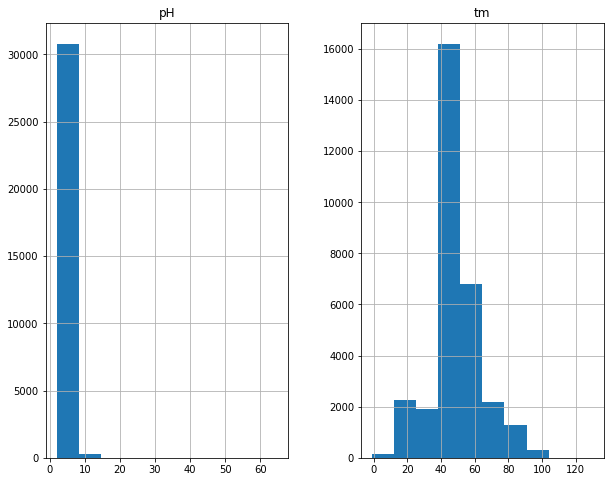

In [91]:
data.hist(figsize=(10, 8));

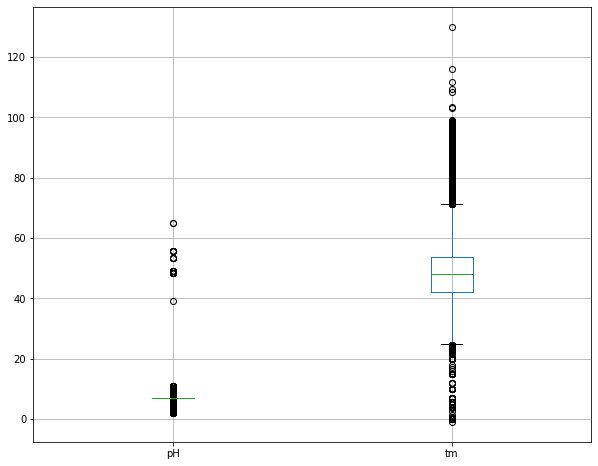

In [92]:
data.boxplot(figsize=(10, 8));

Налицо выбросы.Значения pH варьируются от околонулевых до 14, все, что выше, можно отбросить. Я загуглила и узнала, что существуют белки с высокой стабильностью, превышающей 100 С, но их очень мало. Приняла решение убрать отклонения в соответствии с правилом трех сигм:

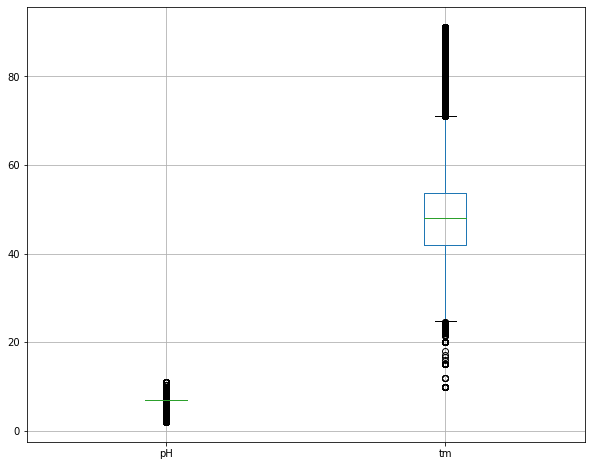

In [163]:
from scipy import stats

# f1 = data[data['pH'] <= 14]
zscore_data = stats.zscore(data['tm'])
filtered_data = data[(np.abs(zscore_data) < 3)]
filtered_data.boxplot(figsize=(10, 8));

In [94]:
filtered_data.shape

(30751, 3)

Хочу посмотреть на размеры белков, пусть лежат в отдельной колонке.

/tmp/ipykernel_31828/3822912735.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(filtered_data['aa_count'].values)


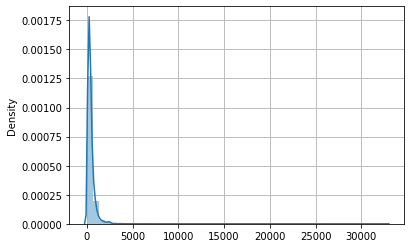

In [169]:
#посмотрим еще на длину каждого белка
filtered_data['aa_count']= filtered_data['protein_sequence'].apply(lambda x: len(x))
sns.distplot(filtered_data['aa_count'].values)
plt.grid(True);

Оцениваем, что получилось после фильтрации: 

In [107]:
filtered_data.describe()

,pH,tm
count,30751.000000,30751.000000
mean,6.851368,48.860187
std,0.859883,13.253489
min,1.990000,9.800000
25%,7.000000,42.000000
50%,7.000000,48.000000
75%,7.000000,53.600000
max,11.000000,91.200000


In [166]:
filtered_data[filtered_data['aa_count'] > 3000].head(20)

,protein_sequence,pH,tm,aa_count
seq_id,,,,
578,ATMDAPKTCSPKQFACRDQITCISKGWRCDGERDCPDGSDEAPEIC...,7.0,57.2,4525
579,ATMDAPKTCSPKQFACRDQITCISKGWRCDGERDCPDGSDEAPEIC...,7.0,52.2,4525
831,DETSAEETQPHYPECVAPMRECDAKSPGGPKCYPEQWYCDGFPDCQ...,7.0,45.5,4835
1312,ELTPPYFNLATGRKIYATATCGQDTDGPELYCKLVGANTEHDHIDY...,7.0,43.0,3689
1417,ETFKKALLFVQRQYPVLASVIQEENGIPFQSVQLSKDLYFVEEDIS...,7.0,36.2,5444
1920,GWNTSEDASIWENYVEDSNYHEFISSESERGLFPNIFNLATNSLIT...,7.0,42.0,3085
2006,IDYEEIHIEDSYETRSRILMVDGNVWLHAGKDKNITFKTTGNGRIY...,7.0,54.9,4024
2707,LRAYDGLSLPEDTETVTASRYGWTYSYLSDDEDLLADDASGDGLGS...,7.0,57.8,3681
2846,MAAAAAEASGPSCSSAAAAAGAGAAGVSEWLVLRDGCMRCDADGLH...,7.0,49.3,4852


У очень больших белков с более чем 3000 аминокислотными остатками значения pH и стабильности средние, интересной связи  обнаружить не удалось. Едем дальше.

In [170]:
filtered_data = filtered_data.drop('aa_count', axis=1)

2. Кодируем аминокислотные последовательности в числовые векторы.

Сначала я попыталась использовать OneHotEncoding, но задумка не прошла по причине проблем с памятью. Тогда пусть будет словарь аминокислота--число, значения которого будут проставляться в последовательности:

In [171]:
aa_list = 'ARNDCQEGHILKMFPSTWYVUO'
for aa in aa_list:
    filtered_data[aa] = filtered_data['protein_sequence'].apply(lambda seq: seq.count(aa) / len(seq))
filtered_data

,protein_sequence,pH,tm,A,R,N,D,C,Q,E,...,M,F,P,S,T,W,Y,V,U,O
seq_id,,,,,,,,,,,,,,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,0.131965,0.073314,0.014663,0.038123,0.002933,0.017595,0.087977,...,0.023460,0.038123,0.052786,0.032258,0.041056,0.011730,0.008798,0.108504,0.0,0.0
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,0.097902,0.104895,0.020979,0.034965,0.000000,0.076923,0.181818,...,0.006993,0.020979,0.027972,0.048951,0.041958,0.010490,0.010490,0.045455,0.0,0.0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,0.100604,0.062374,0.030181,0.054326,0.018109,0.050302,0.064386,...,0.012072,0.042254,0.040241,0.066398,0.060362,0.006036,0.032193,0.060362,0.0,0.0
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,0.075472,0.037736,0.033962,0.071698,0.018868,0.033962,0.109434,...,0.007547,0.045283,0.060377,0.060377,0.071698,0.011321,0.015094,0.052830,0.0,0.0
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,0.059269,0.043418,0.044797,0.053756,0.009649,0.037216,0.053756,...,0.021365,0.022054,0.088215,0.101999,0.082702,0.011027,0.032391,0.085458,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,0.060109,0.076503,0.043716,0.069217,0.021858,0.043716,0.056466,...,0.023679,0.032787,0.045537,0.060109,0.032787,0.023679,0.032787,0.076503,0.0,0.0
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,0.078891,0.053305,0.040512,0.044776,0.010661,0.034115,0.061834,...,0.029851,0.046908,0.040512,0.078891,0.055437,0.010661,0.029851,0.072495,0.0,0.0
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,0.101562,0.023438,0.039062,0.054688,0.007812,0.062500,0.054688,...,0.054688,0.054688,0.046875,0.078125,0.046875,0.031250,0.031250,0.054688,0.0,0.0


/tmp/ipykernel_31828/1026615400.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_mat = filtered_data.corr()


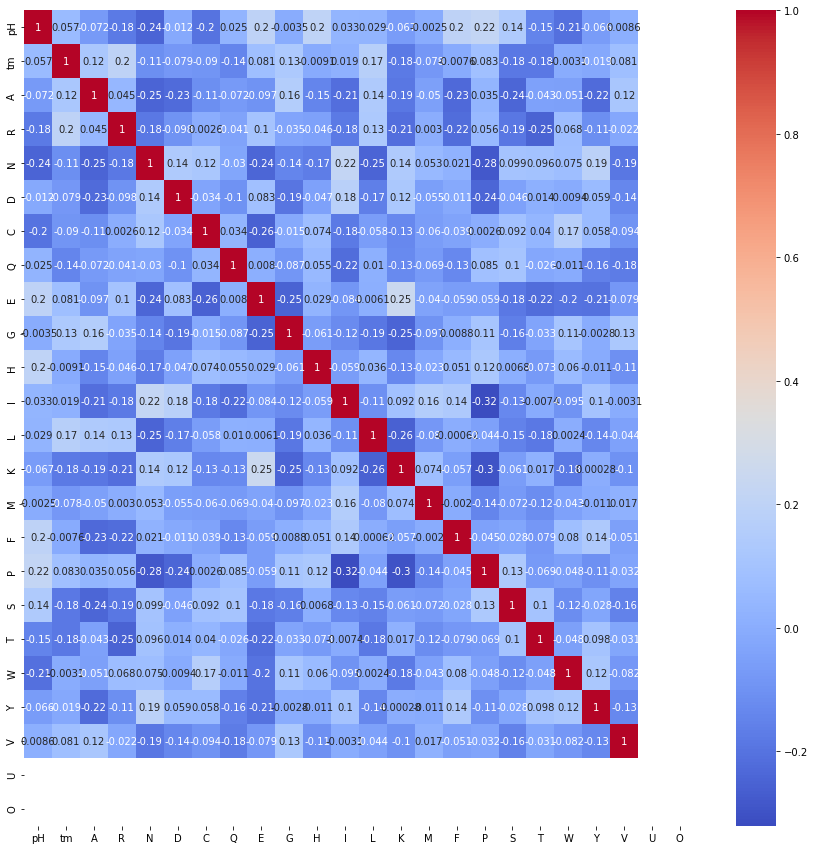

In [172]:
plt.figure(figsize = (15, 15))
cor_mat = filtered_data.corr()
sns.heatmap(cor_mat, annot=True, cmap='coolwarm')
plt.show()

Редких аминокислот все-таки нет, отбросим их. Еще я хочу включить колонки с частотой аминокислот по заряду радикала, может,будет какая-то интересная корреляция с pH.

In [173]:
filtered_data = filtered_data.drop(['U','O'], axis=1)

In [175]:
# Создаем список неполярных, полярных, кислотных и основных аминокислот
nonpolar_aa = ['A', 'G', 'I', 'L', 'M', 'F', 'P', 'W', 'V']
polar_aa = ['R', 'N', 'D', 'E', 'Q', 'H', 'K', 'S', 'T', 'Y', 'C']
acidic_aa = ['D', 'E']
basic_aa = ['R', 'H', 'K']


filtered_data['Nonpolar'] = filtered_data['protein_sequence'].apply(
    lambda seq:sum(seq.count(aa) for aa in nonpolar_aa) / len(seq))

filtered_data['Polar'] = filtered_data['protein_sequence'].apply(
    lambda seq:sum(seq.count(aa) for aa in polar_aa) / len(seq))

filtered_data['Acidic'] = filtered_data['protein_sequence'].apply(
    lambda seq:sum(seq.count(aa) for aa in acidic_aa) / len(seq))

filtered_data['Basic'] = filtered_data['protein_sequence'].apply(
    lambda seq:sum(seq.count(aa) for aa in basic_aa) / len(seq))

In [176]:
filtered_data = filtered_data.drop(['protein_sequence'], axis=1)
filtered_data

,pH,tm,A,R,N,D,C,Q,E,G,...,P,S,T,W,Y,V,Nonpolar,Polar,Acidic,Basic
seq_id,,,,,,,,,,,,,,,,,,,,,
0,7.0,75.7,0.131965,0.073314,0.014663,0.038123,0.002933,0.017595,0.087977,0.111437,...,0.052786,0.032258,0.041056,0.011730,0.008798,0.108504,0.627566,0.372434,0.126100,0.129032
1,7.0,50.5,0.097902,0.104895,0.020979,0.034965,0.000000,0.076923,0.181818,0.062937,...,0.027972,0.048951,0.041958,0.010490,0.010490,0.045455,0.398601,0.601399,0.216783,0.185315
2,7.0,40.5,0.100604,0.062374,0.030181,0.054326,0.018109,0.050302,0.064386,0.130785,...,0.040241,0.066398,0.060362,0.006036,0.032193,0.060362,0.460765,0.539235,0.118712,0.162978
3,7.0,47.2,0.075472,0.037736,0.033962,0.071698,0.018868,0.033962,0.109434,0.060377,...,0.060377,0.060377,0.071698,0.011321,0.015094,0.052830,0.456604,0.543396,0.181132,0.128302
4,7.0,49.5,0.059269,0.043418,0.044797,0.053756,0.009649,0.037216,0.053756,0.057891,...,0.088215,0.101999,0.082702,0.011027,0.032391,0.085458,0.465886,0.534114,0.107512,0.117850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,7.0,51.8,0.060109,0.076503,0.043716,0.069217,0.021858,0.043716,0.056466,0.092896,...,0.045537,0.060109,0.032787,0.023679,0.032787,0.076503,0.477231,0.522769,0.125683,0.162113
31386,7.0,37.2,0.078891,0.053305,0.040512,0.044776,0.010661,0.034115,0.061834,0.057569,...,0.040512,0.078891,0.055437,0.010661,0.029851,0.072495,0.501066,0.498934,0.106610,0.142857
31387,7.0,64.6,0.101562,0.023438,0.039062,0.054688,0.007812,0.062500,0.054688,0.085938,...,0.046875,0.078125,0.046875,0.031250,0.031250,0.054688,0.523438,0.476562,0.109375,0.101562


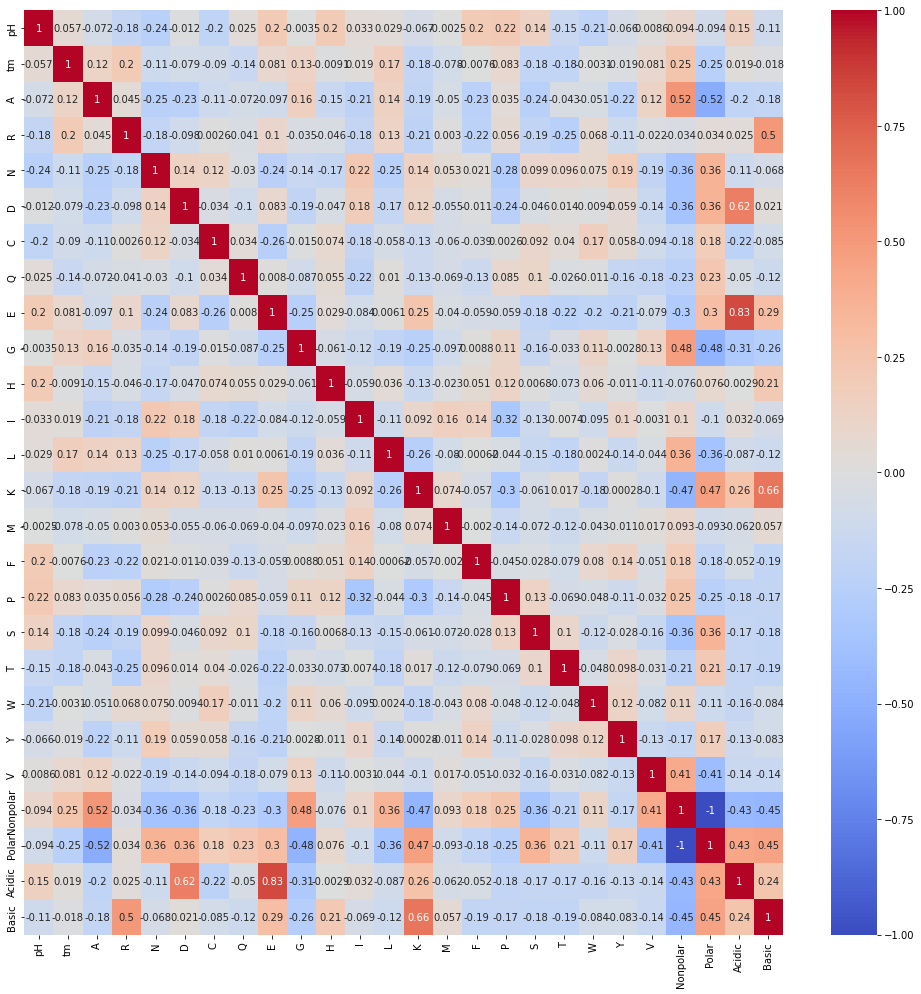

In [178]:
plt.figure(figsize = (17, 17))
cor_mat = filtered_data.corr()
sns.heatmap(cor_mat, annot=True, cmap='coolwarm')
plt.show()

In [191]:
filtered_data.describe()

,pH,tm,A,R,N,D,C,Q,E,G,...,P,S,T,W,Y,V,Nonpolar,Polar,Acidic,Basic
count,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,...,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000
mean,6.851368,48.860187,0.078673,0.053589,0.042925,0.055474,0.014819,0.040919,0.070248,0.069452,...,0.046356,0.067110,0.053341,0.011725,0.031387,0.066837,0.483051,0.516949,0.125722,0.140726
std,0.859883,13.253489,0.028025,0.022344,0.018387,0.017796,0.013412,0.018801,0.025126,0.025269,...,0.021818,0.025238,0.017543,0.009164,0.014286,0.020203,0.056945,0.056945,0.031968,0.031745
min,1.990000,9.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214286,0.181818,0.000000,0.000000
25%,7.000000,42.000000,0.058974,0.038961,0.030769,0.043840,0.006369,0.029661,0.054545,0.053440,...,0.032258,0.048995,0.041916,0.005000,0.021573,0.053991,0.450093,0.486486,0.106788,0.122699
50%,7.000000,48.000000,0.076072,0.051546,0.041335,0.054545,0.012195,0.038622,0.068241,0.066667,...,0.044271,0.064935,0.052475,0.009804,0.030303,0.065421,0.477612,0.522388,0.125000,0.139665
75%,7.000000,53.600000,0.093750,0.065299,0.053008,0.065000,0.019417,0.050429,0.083567,0.083333,...,0.056962,0.082251,0.063868,0.016770,0.039695,0.078292,0.513514,0.549907,0.143317,0.156969
max,11.000000,91.200000,0.298658,0.245399,0.319899,0.205298,0.160714,0.243464,0.246575,0.609195,...,0.269461,0.357143,0.256198,0.080460,0.123180,0.285714,0.818182,0.785714,0.397260,0.400000


Разделение данных на train и test -- попробуем Random Split, доля тестовой выборки - 0.3.

In [179]:
X = np.array(filtered_data.drop(columns=['tm']))
y = filtered_data['tm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Стандартизуем

In [180]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Используем разные модели.

### Linear regression

In [181]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()

k = 5  # Задаем количество фолдов для кросс-валидации
mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=k, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(model, X_train_scaled, y_train, cv=k, scoring='neg_mean_absolute_error')

mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)

# Обучаем модель на обучающей выборке 
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print('Среднее MSE (кросс-валидация):', mean_mse)
print('Среднее MAE (кросс-валидация):', mean_mae)
print('MSE (тестовая выборка):', mse)
print('MAE (тестовая выборка):', mae)
print('R2 (тестовая выборка):', r2)

Среднее MSE (кросс-валидация): 145.29922062400286
Среднее MAE (кросс-валидация): 9.154714129429431
MSE (тестовая выборка): 150.34774437912105
MAE (тестовая выборка): 9.218347874999726
R2 (тестовая выборка): 0.15188092697355882


Все довольно плохо. Пробуем следующую:

### KNN

In [182]:
knn = KNeighborsRegressor()

k = 5  # Задаем количество фолдов для кросс-валидации
mse_scores = -cross_val_score(knn, X_train_scaled, y_train, cv=k, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(knn, X_train_scaled, y_train, cv=k, scoring='neg_mean_absolute_error')

mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)

# Обучаем модель на обучающей выборке 
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print('Среднее MSE (кросс-валидация):', mean_mse)
print('Среднее MAE (кросс-валидация):', mean_mae)
print('MSE (тестовая выборка):', mse)
print('MAE (тестовая выборка):', mae)
print('R2 (тестовая выборка):', r2)

Среднее MSE (кросс-валидация): 80.6161684738676
Среднее MAE (кросс-валидация): 6.248977468060395
MSE (тестовая выборка): 82.84076202037718
MAE (тестовая выборка): 6.278270106221548
R2 (тестовая выборка): 0.5326911581968288


Значения уже лучше, R2 ближе к единице. 

### Random Forest Regressor

In [183]:
from sklearn.ensemble import RandomForestRegressor


In [185]:
rfr = RandomForestRegressor()

k = 5  # Задаем количество фолдов для кросс-валидации
mse_scores = -cross_val_score(rfr, X_train_scaled, y_train, cv=k, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(rfr, X_train_scaled, y_train, cv=k, scoring='neg_mean_absolute_error')

mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)

# Обучаем модель на обучающей выборке 
rfr.fit(X_train_scaled, y_train)
y_pred = rfr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print('Среднее MSE (кросс-валидация):', mean_mse)
print('Среднее MAE (кросс-валидация):', mean_mae)
print('MSE (тестовая выборка):', mse)
print('MAE (тестовая выборка):', mae)
print('R2 (тестовая выборка):', r2)

Среднее MSE (кросс-валидация): 73.79646813720967
Среднее MAE (кросс-валидация): 5.993961321545445
MSE (тестовая выборка): 78.66526123716635
MAE (тестовая выборка): 6.02972075246575
R2 (тестовая выборка): 0.5562453649346968


Еще лучше, а теперь попробуем настроить параметры:

In [161]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

rf_regressor = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],  # количество деревьев в лесу
    'max_depth': [None, 5, 10],  # максимальная глубина деревьев
    'min_samples_split': [5, 10]  # минимальное количество образцов для разделения узла
}

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, n_jobs=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_params


{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 500}

'max_depth' - None

'min_samples_split' - 10

'n_estimators' - 500

In [188]:
forest = RandomForestRegressor(n_estimators=500, min_samples_split=10, random_state=42, max_depth=None)
forest.fit(X_train_scaled, y_train)
y_train_pred = forest.predict(X_train_scaled)
y_test_pred = forest.predict(X_test_scaled)

r2_forest1 = r2_score(y_train, y_train_pred)
r2_forest2 = r2_score(y_test, y_test_pred)


print('R2 (тренировочная выборка):', r2_forest1)
print('R2 (тестовая выборка):', r2_forest2)

R2 (тренировочная выборка): 0.8517214682939025
R2 (тестовая выборка): 0.5767191909227691


Выводы: по значению R2 лучше всего себя показал Random Forest Regressor.

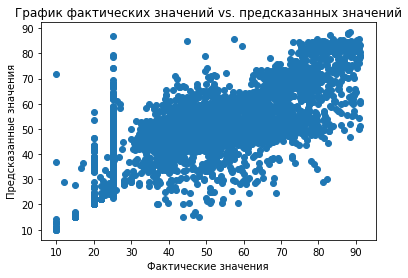

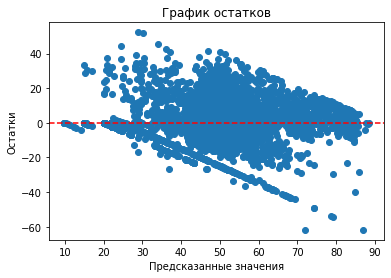

In [189]:
plt.scatter(y_test, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('График фактических значений vs. предсказанных значений')
plt.show()

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.axhline(0, color='red', linestyle='--') 
plt.show()

График фактических значений плюс-минус на диагональной линии, согласование между фактическими и предсказанными значениями есть. 

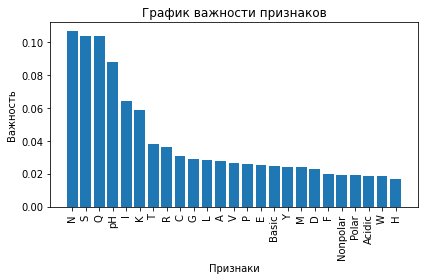

In [190]:
importances = forest.feature_importances_
feature_names = filtered_data.drop(columns=['tm']).columns

# Сортировка важности признаков в порядке убывания
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('График важности признаков')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.tight_layout()
plt.show()

Аспарагин (N), серин (S) и глутамин (Q) - полярные аминокислоты, причем аспарагин и глутамин - единственные aмиды среди 20 основных аминокислот. Можно сделать предположение, что амидный радикал вносит большой вклад в значения стабильности белка. pH же по важности стоит на 4 месте. 